## Data collection part:

1.   use Flickr API to collect real world fruit image data
2.   utilize sketches from QuickDraw dataset in python library

In [1]:
import os
import time
import requests
import pandas as pd
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

import sys,os
import fnmatch
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/5242 final Project')


Mounted at /content/drive


## Real world Image data scraping

### 1.1 Install Python Flickr API

Now import the python interface to Flickr API:

In [ ]:
%pip install flickrapi
from flickrapi import FlickrAPI
key = '73742ad347b80e49c7b7918be71d0830'
secret = 'f749e4af4020f121'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# SIZES = ["url_o", "url_k", "url_h", "url_l", "url_c"]

### 1.2 Acquire Image Links

1. Using “flickr.walk” to returns an iterable object
2. We don’t want to download any image that is too small, and also sometimes it’s not available in certain size. Here we only query choose images in Medium size url_c: Medium 800 (800 × 572) 

In [ ]:
max_count = 5000 #set fetch images number

QURIES = ['apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes','pineapple']    #specify search query

In [ ]:
def fetch_image_link(query):
    flickr = FlickrAPI(key, secret) #initialize python flickr api
    photos = flickr.walk(text=query,
                        tag_mode='all',
                        privacy_filter=1,  # search only for public photos
                        extras='url_c', #specify meta data to be fetched
                        sort='relevance')   #sort search result based on relevance (high to low by default)
   
    urls = []
    count = 0
    for photo in photos:
        if count < max_count:
            count = count + 1
            #print("Fetching url for image number {}".format(count))
            try:
                url = photo.get('url_c')
                urls.append(url)
            except:
                print("Url for image number {} could not be fetched".format(count))
        else:
            print(f"Done fetching {query} urls, fetched {len(urls)} urls out of {max_count}")
            break
    return urls
    
for query in QURIES:
    urls = fetch_image_link(query)
    print('example url:', urls[0])
    urls = pd.Series(urls)
    save_path = './Flickr_scrape_1108/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    category_path = f'{save_path}/{query}_1108_banana_urls.csv'
    print(f"Writing {query} urls to {category_path}")
    urls.to_csv(category_path)

Done fetching banana fruit urls, fetched 5000 urls out of 5000
example url: https://live.staticflickr.com/4749/28301749099_b15f9ac597_c.jpg
Writing banana fruit urls to ./Flickr_scrape_1108//banana fruit_1108_banana_urls.csv


### 1.3 Download files using acquired links

Till now we have collected the image urls. Now we will use the *request* package to download the image files.

In [ ]:
CATEGORIES = QURIES   #specify search query

In [ ]:
sys.path[0]

'/content/drive/My Drive/Colab Notebooks/5242 final Project'

In [ ]:
def fetch_files_with_link(url_path):
    with open(url_path, newline="") as csvfile:
        urls = pd.read_csv(url_path, delimiter=',')
        urls = urls.iloc[:, 1].to_dict().values()
        
    SAVE_PATH = os.path.join(url_path.replace('_urls.csv', ''))
    if not os.path.isdir(SAVE_PATH):
        os.mkdir(SAVE_PATH) #define image storage path
    failed = 0
    for idx, url in tqdm(enumerate(urls), total=len(urls)):
        try:
            resp = requests.get(url, stream=True)   #request file using url
            path_to_write = os.path.join(SAVE_PATH, str(idx)+'.jpg')
            outfile = open(path_to_write, 'wb')
            outfile.write(resp.content) #save file content
            outfile.close()
        except:
            failed +=1
    #print(f"Done with {url_path} download, images are saved in {SAVE_PATH}")
    print(f"images are saved in {SAVE_PATH}")
    print("Successfully download {} urls".format(len(urls)-failed))
    print("Failed to download {} urls".format(failed))

print("Start downloading images...")


save_path = sys.path[0] +'/Flickr_scrape_1108/'
for category in CATEGORIES:
    url_path = f'{save_path}{category}_1108_banana_urls.csv'
    fetch_files_with_link(url_path)

Start downloading images...


100%|██████████| 5000/5000 [15:47<00:00,  5.28it/s]

images are saved in /content/drive/My Drive/Colab Notebooks/5242 final Project/Flickr_scrape_1108/banana fruit_1108_banana
Successfully download 4523 urls
Failed to download 477 urls


### 1.4 Visualize Collected Image

You can visualize sample images in a jupyter notebook

In [ ]:
import ipywidgets as widgets
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import cv2

def plot_samples(category):
    paths = sorted(glob(f'./Flickr_scrape/{category}/*.*'))
    paths = np.random.choice(paths, 4, replace=False)

    plt.figure(figsize=(12,12))
    for i in range(4):
        image = cv2.imread(paths[i])[...,[2,1,0]]
        image = cv2.resize(image, (512,512), interpolation=cv2.INTER_LINEAR)
        plt.subplot(1, 4, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

all_categories = QURIES
widgets.interact_manual.opts['manual_name'] = 'Show samples'
im = widgets.interact_manual(lambda category: plot_samples(category), category=all_categories)

interactive(children=(Dropdown(description='category', options=('apple', 'banana', 'strawberry', 'pear', 'wate…

## Sketch fruit image from QuickDraw API
After collecting the real fruit images dataset, we use another API  `quickdraw` to access the Google Quick, Draw! data [quickdraw.withgoogle.com/data](https://quickdraw.withgoogle.com/data)

### 2.1 Import packages 

In [3]:
%pip install quickdraw
%pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from quickdraw import QuickDrawData , QuickDrawDataGroup


### 2.2 Fetching QuickDrawing objects

Drawings are returned as QuickDrawing objects which exposes the properties of the drawing.
Open a group of Quick Draw drawings using QuickDrawDataGroup passing the name of the drawing.


In [11]:
max_count = 10000  #set fetch images number
categories = ['apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes','pineapple']  
label_dict = {}  
classes = {}


In [ ]:
for i,quires in enumerate(categories):
    # create lable and classes
    label_dict[i]= quires
    classes[quires] = QuickDrawDataGroup(quires, max_drawings= max_count)

    save_path = sys.path[0]+'/quickdraw/'+ quires
    print(save_path)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    idx = 0
    for i in classes[quires].drawings:
      category_path = save_path +'/'

      i.image.save(category_path+str(idx)+'.jpg')
      idx += 1
    print(quires,classes[quires].drawing_count)
print(label_dict)
print(classes)

downloading apple from https://storage.googleapis.com/quickdraw_dataset/full/binary/apple.bin
download complete
loading apple drawings
load complete
/content/drive/My Drive/Colab Notebooks/5242 final Project/quickdraw/apple
apple 10000
downloading banana from https://storage.googleapis.com/quickdraw_dataset/full/binary/banana.bin
download complete
loading banana drawings
load complete
/content/drive/My Drive/Colab Notebooks/5242 final Project/quickdraw/banana
banana 10000
downloading strawberry from https://storage.googleapis.com/quickdraw_dataset/full/binary/strawberry.bin
download complete
loading strawberry drawings
load complete
/content/drive/My Drive/Colab Notebooks/5242 final Project/quickdraw/strawberry
strawberry 10000
downloading pear from https://storage.googleapis.com/quickdraw_dataset/full/binary/pear.bin
download complete
loading pear drawings
load complete
/content/drive/My Drive/Colab Notebooks/5242 final Project/quickdraw/pear
pear 10000
downloading watermelon from htt

### 2.3 Visualize sketch Image Data

Returns a PIL Image object of the drawing on a white background with a black drawing. Alternative image parameters can be set using get_image().

To save the image you would use the save method

loading apple drawings
load complete
loading banana drawings
load complete
loading strawberry drawings
load complete
loading pear drawings
load complete
loading watermelon drawings
load complete
loading grapes drawings
load complete
loading pineapple drawings
load complete


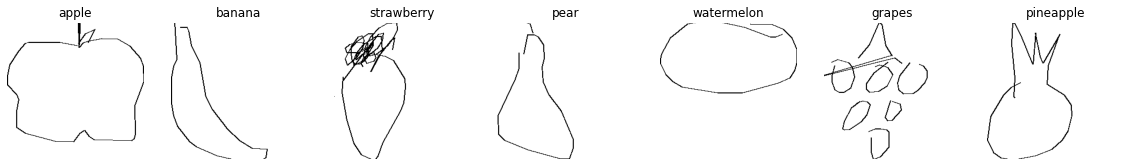

In [49]:
plt.figure(figsize=(20, 15)) # Makes the plot bigger
cols = 1
index=1
for fruit in categories:
   qd = QuickDrawDataGroup(fruit,1)
   img = qd.get_drawing().get_image()
   plt.subplot(1,len(categories), index)
   plt.imshow(img)
   plt.title(fruit)
   plt.axis('off')
   index+=1;

plt.show()
   